Fine-tuning mT5 for Amharic text Summerization


In [1]:
# Installing Packages
!pip install datasets transformers sentencepiece accelerate -U tensorflow --upgrade torch torchvision peft nltk rouge_score  > /dev/null 2>&1

In [2]:
# Loading packages
import re
import sys
import os
import time
import random
import torch
import pandas as pd
from datasets import load_dataset, Dataset, DatasetDict
from peft import LoraConfig, TaskType, get_peft_model
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    default_data_collator,
    get_linear_schedule_with_warmup,
    MT5Tokenizer,
)
from tqdm import tqdm
from torch.utils.data import DataLoader
from rouge_score import rouge_scorer
from google.colab import drive

## Data Loading and Preprocessing

In [3]:
# Mouting Google Drive to the current Colab session for accessing files stored in the Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Path of the directory of the data files
folder_path = '/content/drive/MyDrive/mT5-PEFT-Amharic-Text-Summarization-main/'

# Specific paths to training, validation and test files
train_path = folder_path + 'amharic_2_train.csv'
valid_path = folder_path + 'amharic_2_valid.csv'
test_path = folder_path + 'amharic_2_test.csv'

In [5]:
# Normalization steps
# The following three functions are taken from: https://abe2g.github.io/am-preprocess.html
# The full source is cited in detail in the final report
# These steps are applied to the dataset this step hasn't already be applied on (i.e., Amharic-2)
# Amharic-3 goes through these steps during its preparation phase.
# These steps weren't included during the use of Amharic-1.

def normalize_char_level_missmatch(input_token):
  '''
    Normalize variations of Amharic characters in a given token to standardize them.

    Args:
        input_token (str): The Amharic token to be normalized.

    Returns:
        str: The normalized Amharic token.
  '''

  rep1=re.sub('[ሃኅኃሐሓኻ]','ሀ',input_token)
  rep2=re.sub('[ሑኁዅ]','ሁ',rep1)
  rep3=re.sub('[ኂሒኺ]','ሂ',rep2)
  rep4=re.sub('[ኌሔዄ]','ሄ',rep3)
  rep5=re.sub('[ሕኅ]','ህ',rep4)
  rep6=re.sub('[ኆሖኾ]','ሆ',rep5)
  rep7=re.sub('[ሠ]','ሰ',rep6)
  rep8=re.sub('[ሡ]','ሱ',rep7)
  rep9=re.sub('[ሢ]','ሲ',rep8)
  rep10=re.sub('[ሣ]','ሳ',rep9)
  rep11=re.sub('[ሤ]','ሴ',rep10)
  rep12=re.sub('[ሥ]','ስ',rep11)
  rep13=re.sub('[ሦ]','ሶ',rep12)
  rep14=re.sub('[ዓኣዐ]','አ',rep13)
  rep15=re.sub('[ዑ]','ኡ',rep14)
  rep16=re.sub('[ዒ]','ኢ',rep15)
  rep17=re.sub('[ዔ]','ኤ',rep16)
  rep18=re.sub('[ዕ]','እ',rep17)
  rep19=re.sub('[ዖ]','ኦ',rep18)
  rep20=re.sub('[ጸ]','ፀ',rep19)
  rep21=re.sub('[ጹ]','ፁ',rep20)
  rep22=re.sub('[ጺ]','ፂ',rep21)
  rep23=re.sub('[ጻ]','ፃ',rep22)
  rep24=re.sub('[ጼ]','ፄ',rep23)
  rep25=re.sub('[ጽ]','ፅ',rep24)
  rep26=re.sub('[ጾ]','ፆ',rep25)

  #Normalizing words with Labialized Amharic characters such as በልቱዋል or  በልቱአል to  በልቷል
  rep27=re.sub('(ሉ[ዋአ])','ሏ',rep26)
  rep28=re.sub('(ሙ[ዋአ])','ሟ',rep27)
  rep29=re.sub('(ቱ[ዋአ])','ቷ',rep28)
  rep30=re.sub('(ሩ[ዋአ])','ሯ',rep29)
  rep31=re.sub('(ሱ[ዋአ])','ሷ',rep30)
  rep32=re.sub('(ሹ[ዋአ])','ሿ',rep31)
  rep33=re.sub('(ቁ[ዋአ])','ቋ',rep32)
  rep34=re.sub('(ቡ[ዋአ])','ቧ',rep33)
  rep35=re.sub('(ቹ[ዋአ])','ቿ',rep34)
  rep36=re.sub('(ሁ[ዋአ])','ኋ',rep35)
  rep37=re.sub('(ኑ[ዋአ])','ኗ',rep36)
  rep38=re.sub('(ኙ[ዋአ])','ኟ',rep37)
  rep39=re.sub('(ኩ[ዋአ])','ኳ',rep38)
  rep40=re.sub('(ዙ[ዋአ])','ዟ',rep39)
  rep41=re.sub('(ጉ[ዋአ])','ጓ',rep40)
  rep42=re.sub('(ደ[ዋአ])','ዷ',rep41)
  rep43=re.sub('(ጡ[ዋአ])','ጧ',rep42)
  rep44=re.sub('(ጩ[ዋአ])','ጯ',rep43)
  rep45=re.sub('(ጹ[ዋአ])','ጿ',rep44)
  rep46=re.sub('(ፉ[ዋአ])','ፏ',rep45)
  rep47=re.sub('[ቊ]','ቁ',rep46) #ቁ can be written as ቊ
  rep48=re.sub('[ኵ]','ኩ',rep47) #ኩ can be also written as ኵ
  return rep48

# :: No longer removed
def remove_punc_and_special_chars(text):
  '''
    Remove punctuation and special characters from a given text.

    Args:
        text (str): The text from which to remove punctuation and special characters.

    Returns:
        str: The text stripped of punctuation and special characters.
  '''

  normalized_text = re.sub('[\!\@\#\$\%\^\«\»\&\*\(\)\…\[\]\{\}\;\“\”\›\’\‘\"\'\:\,\.\‹\/\<\>\?\\\\|\`\´\~\-\=\+\፡\፤\;\፦\፥\፧\፨\፠\፣]', '',text)
  return normalized_text

# Remove all ascii characters
def remove_ascii_and_numbers(text_input):
  '''
    Remove ASCII characters and numbers from the given text.

    Args:
        text_input (str): The text from which to remove ASCII characters and numbers.

    Returns:
        str: The text without any ASCII characters and numbers.
  '''

  return re.sub('[A-Za-z]','',text_input)

In [6]:
def preprocess_function(examples, tokenizer):
  '''
    Preprocess text and summary data for tokenization suitable for mT5 model training.

    Args:
        examples (dict): A dictionary containing 'text' and 'summary' keys with lists of strings as values.
        tokenizer: The tokenizer to be used for tokenizing the text and summary.

    Returns:
        dict: A dictionary with tokenized input data and labels suitable for mT5 model training.
  '''

  padding = "max_length"
  max_length = 512
  max_summary_length = 128

  # Apply preprocessing steps to inputs and targets
  inputs = [normalize_char_level_missmatch(remove_ascii_and_numbers(remove_punc_and_special_chars(ex))) for ex in examples["Article "]]
  targets = [normalize_char_level_missmatch(remove_ascii_and_numbers(remove_punc_and_special_chars(ex))) for ex in examples["summary"]]

  # Tokenize inputs and labels
  model_inputs = tokenizer(inputs, max_length=max_length, padding=padding, truncation=True)
  labels = tokenizer(targets, max_length=max_summary_length, padding=padding, truncation=True)

  # Adjust labels for mT5
  labels["input_ids"] = [
      [(label if label != tokenizer.pad_token_id else -100) for label in label_seq] for label_seq in labels["input_ids"]
  ]

  # Setting the tokenized labels as the model's training targets
  model_inputs["labels"] = labels["input_ids"]
  return model_inputs

In [7]:
# Loading dataset
datasets = load_dataset("csv", data_files={"train": train_path, "validation": valid_path, "test": test_path})

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [8]:
# Loading mT5's tokenizer
tokenizer = MT5Tokenizer.from_pretrained('google/mt5-small')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'T5Tokenizer'. 
The class this function is called from is 'MT5Tokenizer'.
You are using the default legacy behaviour of the <class 'transformers.models.mt5.tokenization_mt5.MT5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [9]:
# Performing preprocessing and tokenizations on each entry
tokenized_datasets = datasets.map(
    lambda examples: preprocess_function(examples, tokenizer),
    batched=True
)

tokenized_datasets["train"] = tokenized_datasets["train"].shuffle(seed=16)

Map:   0%|          | 0/16003 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2001 [00:00<?, ? examples/s]

In [10]:
# Save processed data the first time it is processed (if it is the first time, the next line would be uncommented)
tokenized_datasets.save_to_disk(folder_path + 'brand_new_further_cleaned_Amharic_mT5_tokenized_datasets')

# Load processed data if it has already been saved
# This is referencing the tokenized, preprocessed version of Amharic-2
tokenized_datasets = DatasetDict.load_from_disk(folder_path + 'brand_new_further_cleaned_Amharic_mT5_tokenized_datasets')

Saving the dataset (0/1 shards):   0%|          | 0/16003 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2001 [00:00<?, ? examples/s]

## Loading Model

In [19]:
# Getting the base model and setting up the IA3 PEFT cofigurations
# Changes indicate from: Initial-Amharic-FT -> Improved-Amharic-FT
base_model = AutoModelForSeq2SeqLM.from_pretrained('google/mt5-small')
peft_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,
    inference_mode=False,
    r=16,                      # Increase LoRA rank
    lora_alpha=32,             # More scaling
    lora_dropout=0.1,
    target_modules=["q", "k", "v", "o", "wi", "wo"]  # Add more attention and FFN modules
)

model = get_peft_model(base_model, peft_config)
model.print_trainable_parameters()

trainable params: 1,769,472 || all params: 301,946,240 || trainable%: 0.5860


## Training Hyperparameters

In [20]:
# Initializing training hyperparameters
num_epochs = 5
batch_size = 8

In [21]:
# Initializing optimizer and LR scheduler with IA3 parameters
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4) # Starting LR increased from 5e-5 to 2e-4 for Improved models

# Loading training data
train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle = True,
    collate_fn = default_data_collator,
    batch_size = batch_size,
    pin_memory = True,
)

# Loading validation data
validation_dataloader = DataLoader(
    tokenized_datasets["validation"],
    collate_fn = default_data_collator,
    batch_size = batch_size,
    pin_memory = True
)

# Number of training steps
num_training_steps = len(train_dataloader) * num_epochs

# Setting up the learning rate scheduler
# Changed to 30% warmup for Improved model
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer = optimizer,
    num_warmup_steps = int(0.3 * num_training_steps), # 10% warmup, increased to 30% for Improved Amharic models
    num_training_steps = num_training_steps,
)

In [32]:
# Path to save checkpoints
checkpoint_path ="/content/drive/MyDrive/mT5-PEFT-Amharic-Text-Summarization-main/CPSC_490_Data/"

# Early stopping parameters
patience = 3  # How many epochs to wait after last time validation loss improved

## Training Loop

In [33]:
# Setting the device for the model training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
import sys

# Set path to where training_module.py is located
folder_path = '/content/drive/MyDrive/mT5-PEFT-Amharic-Text-Summarization-main/mT5-PEFT-Amharic-Text-Summarization-main/'
import sys
sys.path.append(folder_path)

from training_module import train_model, save_losses


In [35]:
# Training/Fine-tuning the model
training_losses, validation_losses = train_model(
    model = model,
    train_dataloader = train_dataloader,
    validation_dataloader = validation_dataloader,
    optimizer = optimizer,
    lr_scheduler = lr_scheduler,
    device = device,
    num_epochs = num_epochs,
    checkpoint_filepath = checkpoint_path,
    patience = patience,
    model_filepath = folder_path + "Improved_Amharic_FT"
)

100%|██████████| 250/250 [00:16<00:00, 14.76it/s]


Epoch 0: Training Loss = 1.336273825895423, Validation Loss = 0.1899184554964304
Current Learning Rate: 0.00017141633352370074


100%|██████████| 250/250 [00:16<00:00, 14.92it/s]


Epoch 1: Training Loss = 0.6030374768300393, Validation Loss = 0.15825388470292093
Current Learning Rate: 0.00011427755568246717


100%|██████████| 250/250 [00:16<00:00, 14.81it/s]


Epoch 2: Training Loss = 0.411229444973949, Validation Loss = 0.14189458202570676
Current Learning Rate: 5.713877784123358e-05


100%|██████████| 250/250 [00:16<00:00, 14.80it/s]


Epoch 3: Training Loss = 0.3393050807564036, Validation Loss = 0.13421126917004586
Current Learning Rate: 0.0


100%|██████████| 250/250 [00:16<00:00, 15.03it/s]


Epoch 4: Training Loss = 0.3257109559904868, Validation Loss = 0.13421126917004586
Current Learning Rate: 0.0
Total Training Time:  1669.1691641807556
Model saved at:  /content/drive/MyDrive/mT5-PEFT-Amharic-Text-Summarization-main/mT5-PEFT-Amharic-Text-Summarization-main/Improved_Amharic_FT


In [ ]:
# ✅ Step 1: Install Required Packages
!pip install  huggingface_hub

# ✅ Step 2: Log In to Hugging Face
from huggingface_hub import login
login(" ")  # Replace with your actual token


In [47]:
# ✅ Step 3: Load and Merge LoRA with Base mT5
from peft import PeftModel
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# Load the base model
base_model = AutoModelForSeq2SeqLM.from_pretrained("google/mt5-small")

# Load the trained LoRA adapter
peft_model = PeftModel.from_pretrained(
    base_model,
    folder_path + "Improved_Amharic_FT"
)

# Merge LoRA adapter weights into base model
merged_model = peft_model.merge_and_unload()


In [48]:
# ✅ Step 4: Save Merged Model + Tokenizer Locally
save_path = "/content/drive/MyDrive/mT5-PEFT-Amharic-Text-Summarization-main/amharic-mt5-with-lora-final"

merged_model.save_pretrained(save_path)
tokenizer = AutoTokenizer.from_pretrained("google/mt5-small")
tokenizer.save_pretrained(save_path)


('/content/drive/MyDrive/mT5-PEFT-Amharic-Text-Summarization-main/amharic-mt5-with-lora-final/tokenizer_config.json',
 '/content/drive/MyDrive/mT5-PEFT-Amharic-Text-Summarization-main/amharic-mt5-with-lora-final/special_tokens_map.json',
 '/content/drive/MyDrive/mT5-PEFT-Amharic-Text-Summarization-main/amharic-mt5-with-lora-final/spiece.model',
 '/content/drive/MyDrive/mT5-PEFT-Amharic-Text-Summarization-main/amharic-mt5-with-lora-final/added_tokens.json',
 '/content/drive/MyDrive/mT5-PEFT-Amharic-Text-Summarization-main/amharic-mt5-with-lora-final/tokenizer.json')

In [49]:
# ✅ Step 5: Push Final Merged Model to Hugging Face Hub
merged_model.push_to_hub("Desalegnn/amharic-mt5-with-LoRA")
tokenizer.push_to_hub("Desalegnn/amharic-mt5-with-LoRA")


model.safetensors:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/16.3M [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/Desalegnn/amharic-mt5-with-LoRA/commit/00fc5c2ede5694d76323d8c862482f72f9e8f236', commit_message='Upload tokenizer', commit_description='', oid='00fc5c2ede5694d76323d8c862482f72f9e8f236', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Desalegnn/amharic-mt5-with-LoRA', endpoint='https://huggingface.co', repo_type='model', repo_id='Desalegnn/amharic-mt5-with-LoRA'), pr_revision=None, pr_num=None)

In [50]:
# Saving the training and validation losses at each step to a CSV file
save_losses(
    training_losses = training_losses,
    validation_losses = validation_losses,
    file_path = folder_path + "improved_amharic_ft_losses.csv"
)

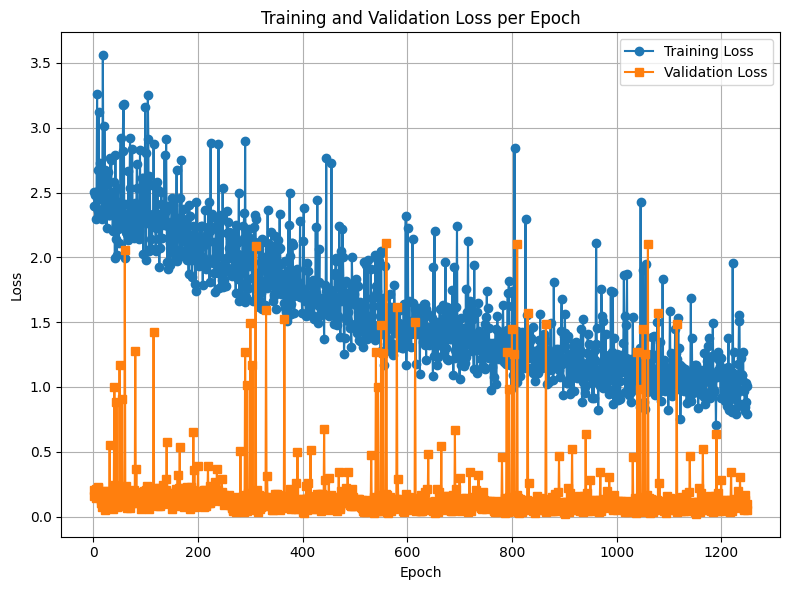

In [65]:
import matplotlib.pyplot as plt

# Example: training_losses and validation_losses are lists returned from train_model()
# Ensure they have the same length = num_epochs
epochs = range(1, len(training_losses) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, training_losses, label='Training Loss', marker='o')
plt.plot(epochs, validation_losses, label='Validation Loss', marker='s')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [53]:
plt.savefig(folder_path + "loss_curve.png")


<Figure size 640x480 with 0 Axes>